In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [2]:
polity_df = download_data("https://seshatdata.com/api/core/polities/")
dataset = TSD(file_path=f'../datasets/100y_dataset_imputed.xlsx')

Downloaded 839 rows
Dataset loaded from ../datasets\100y_dataset_imputed.xlsx


In [3]:
import pyreadr

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)
df['PolityName'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'new_name'].values[0] if x in polity_df['name'].values else np.nan)
df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'id'].values[0] if x in polity_df['name'].values else np.nan)
df.drop_duplicates(subset=['PolityName', 'Year'], inplace=True)
# dataset.scv = df
# dataset.scv_imputed = df
df_old = df.copy()

In [4]:
if 'Agri' not in dataset.scv.columns:
    add_cols = ['Agri','AgriLag']
    for col in add_cols:
        dataset.scv[col] = np.nan
    # add cols to dataset by merging on PolityID and year from df_agri
    for n, row in df.iterrows():
        for col in add_cols:
            dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year']), col] = row[col]
            if len(dataset.scv.loc[(dataset.scv['PolityName'] == row['PolityName']) & (dataset.scv['Year'] == row['Year'])]) > 1:
                print(row['PolityName'], row['Year'])
                

    for pol in dataset.scv.PolityName.unique(): 
        for col in add_cols:
            if dataset.scv.loc[dataset.scv['PolityName'] == pol, col].isna().any() and dataset.scv.loc[dataset.scv['PolityName'] == pol, col].notna().any():
                if col == 'Agri':
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(method='ffill')
                elif col == 'AgriLag':
                    # calculate change in year and add to agrilag value
                    agrilag = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), col].iloc[0]
                    year = dataset.scv.loc[(dataset.scv['PolityName'] == pol)&(dataset.scv["AgriLag"].notna()), 'Year'].iloc[0]
                    year_diff = year - dataset.scv.loc[(dataset.scv['PolityName'] == pol), 'Year']
                    dataset.scv.loc[dataset.scv['PolityName'] == pol, col] = dataset.scv.loc[dataset.scv['PolityName'] == pol, col].fillna(agrilag - year_diff)

transfer_cols = ['Agri','AgriLag','Miltech','IronCav','Cavalry']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

In [5]:
# scale_cols = ['Pop','Terr','Cap']
# dataset.scv.loc[dataset.scv[scale_cols].isna().sum(axis=1)>2, 'Scale_1'] = np.nan
# dataset.scv.loc[dataset.scv[non_scale_cols].isna().sum(axis=1)>2, 'Comp'] = np.nan

# dataset.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
# # rescale the PCA according to variable Pop

# # Fit linear model to rescale the PCA according to variable Pop
# lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
# X = lm_df[['Pop']]
# y = lm_df['Scale_1']

# # Create and fit the model
# model = LinearRegression()
# model.fit(X, y)

# # Extract the coefficients
# intercept = model.intercept_
# slope = model.coef_[0]

# # Adjust the Scale_1 column
# dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope

# comp_mapping = {'Comp':{'Government': 11, 'Infrastructure': 12, 'Information':13, 'Money': 6}}
# # dataset.scv_imputed['Comp'] = (dataset.scv_imputed['Government']*11 + dataset.scv_imputed['Infrastructure']*12 + dataset.scv_imputed['Information']*13 + dataset.scv_imputed['Money']*6)/(11+13+12+6)
# dataset.scv_imputed['Comp'] = dataset.scv_imputed.apply(lambda row: weighted_mean(row, comp_mapping,category = 'Comp',imputation = "remove"), axis=1)
# miltech_mapping = {'Miltech':{'Metal': 1, 'Project': 1, 'Weapon':1, 'Armor': 1, 'Animal': 1, 'Defense': 1}}
# dataset.build_warfare()
# dataset.scv['Miltech'] = dataset.scv[miltech_mapping['Miltech']].sum(axis=1)
# dataset.scv['IronCav'] = dataset.scv.apply(lambda row: row["Iron"] + row["Cavalry"], axis=1)

# transfer_cols = ['Agri','AgriLag','Miltech','IronCav','Cavalry']
# for col in transfer_cols:
#     dataset.scv_imputed[col] = dataset.scv[col]

          PolityName  Year   Pop_old   Pop_new      diff
668   mn_mongol_late  1500  6.415277  4.739053  1.676225
667   mn_mongol_late  1400  6.415277  4.739053  1.676225
195      eg_naqada_1 -3800  2.555193  4.113943  1.558750
1308      pe_cuzco_5  1000  4.439889  5.893145  1.453256
1309      pe_cuzco_5  1100  4.439889  5.893145  1.453256
1310      pe_cuzco_5  1200  4.439889  5.893145  1.453256
842     in_deccan_nl -2500  2.514491  3.912015  1.397524
848     in_deccan_nl -1900  2.514491  3.912015  1.397524
849     in_deccan_nl -1800  2.514491  3.912015  1.397524
850     in_deccan_nl -1700  2.514491  3.912015  1.397524


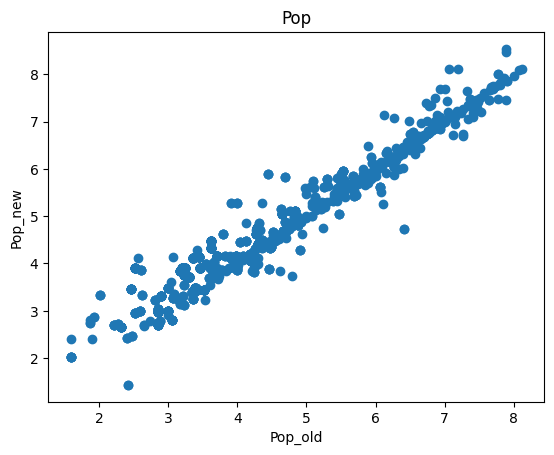

                  PolityName  Year  Terr_old  Terr_new      diff
747  pk_kachi_proto_historic  -700  1.907470  3.797168  1.889698
741  pk_kachi_proto_historic -1300  1.907470  3.797168  1.889698
746  pk_kachi_proto_historic  -800  1.907470  3.797168  1.889698
745  pk_kachi_proto_historic  -900  1.907470  3.797168  1.889698
744  pk_kachi_proto_historic -1000  1.907470  3.797168  1.889698
743  pk_kachi_proto_historic -1100  1.907470  3.797168  1.889698
742  pk_kachi_proto_historic -1200  1.907470  3.797168  1.889698
748  pk_kachi_proto_historic  -600  1.907470  3.797168  1.889698
332              iq_ur_dyn_3 -2100  4.201310  5.735042  1.533732
63             fr_beaker_eba -2400  1.848933  3.182068  1.333136


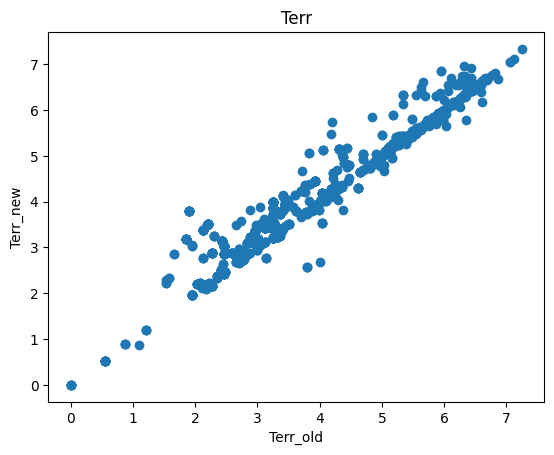

               PolityName  Year   Cap_old   Cap_new      diff
585        et_aksum_emp_1   200  5.009663  3.745245  1.264419
361   ir_seljuk_sultanate  1100  4.954824  5.892214  0.937389
755  af_ghur_principality  1200  4.635879  5.514050  0.878171
24           it_latium_ba -1200  1.544068  2.395859  0.851791
547      tr_ottoman_emp_1  1500  4.740363  5.493215  0.752852
905           kh_angkor_1  1000  4.938740  5.602060  0.663320
851          in_deccan_nl -1600  2.262518  2.916991  0.654473
850          in_deccan_nl -1700  2.262518  2.916991  0.654473
854          in_deccan_nl -1300  2.262518  2.916991  0.654473
848          in_deccan_nl -1900  2.262518  2.916991  0.654473


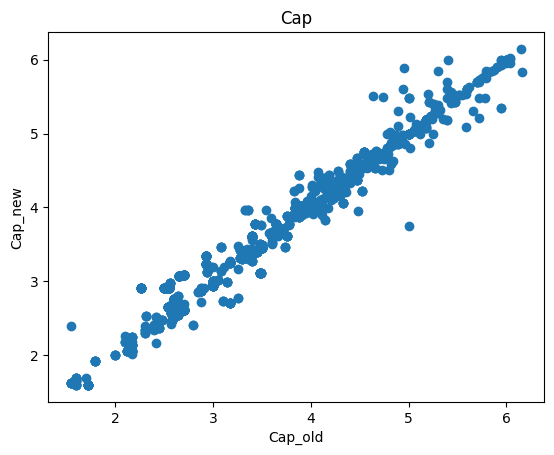

            PolityName  Year  Hierarchy_old  Hierarchy_new      diff
836  in_gahadavala_dyn  1100           5.00       6.900872  1.900872
233     sy_umayyad_cal   700           5.75       4.101152  1.648848
230   eg_ptolemaic_k_1  -300           7.00       5.500000  1.500000
448          il_canaan -1200           6.50       5.003056  1.496944
440          il_canaan -2000           6.50       5.003056  1.496944
447          il_canaan -1300           6.50       5.003056  1.496944
446          il_canaan -1400           6.50       5.003056  1.496944
445          il_canaan -1500           6.50       5.003056  1.496944
443          il_canaan -1700           6.50       5.003056  1.496944
442          il_canaan -1800           6.50       5.003056  1.496944


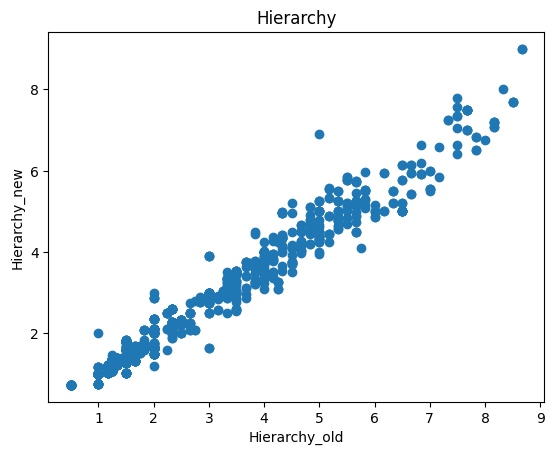

       PolityName  Year  Government_old  Government_new      diff
919       id_buni   100             0.0        0.668716  0.668716
956  cn_peiligang -5300             0.0        0.668716  0.668716
946  cn_peiligang -6300             0.0        0.668716  0.668716
947  cn_peiligang -6200             0.0        0.668716  0.668716
948  cn_peiligang -6100             0.0        0.668716  0.668716
949  cn_peiligang -6000             0.0        0.668716  0.668716
950  cn_peiligang -5900             0.0        0.668716  0.668716
951  cn_peiligang -5800             0.0        0.668716  0.668716
952  cn_peiligang -5700             0.0        0.668716  0.668716
953  cn_peiligang -5600             0.0        0.668716  0.668716


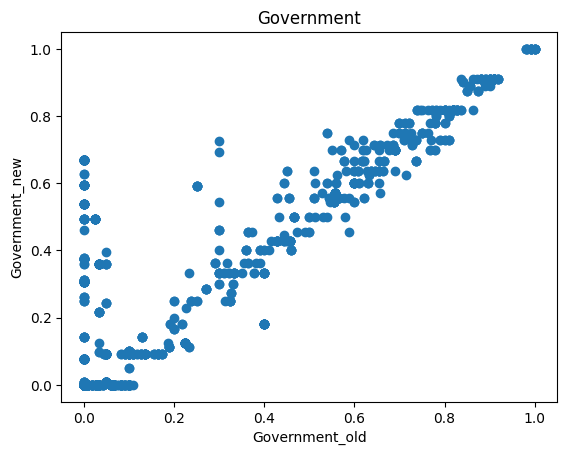

       PolityName  Year  Infrastructure_old  Infrastructure_new  diff
955  cn_peiligang -5400                 0.5                 1.0   0.5
945  cn_peiligang -6400                 0.5                 1.0   0.5
956  cn_peiligang -5300                 0.5                 1.0   0.5
958  cn_peiligang -5100                 0.5                 1.0   0.5
957  cn_peiligang -5200                 0.5                 1.0   0.5
940  cn_peiligang -6900                 0.5                 1.0   0.5
941  cn_peiligang -6800                 0.5                 1.0   0.5
942  cn_peiligang -6700                 0.5                 1.0   0.5
943  cn_peiligang -6600                 0.5                 1.0   0.5
944  cn_peiligang -6500                 0.5                 1.0   0.5


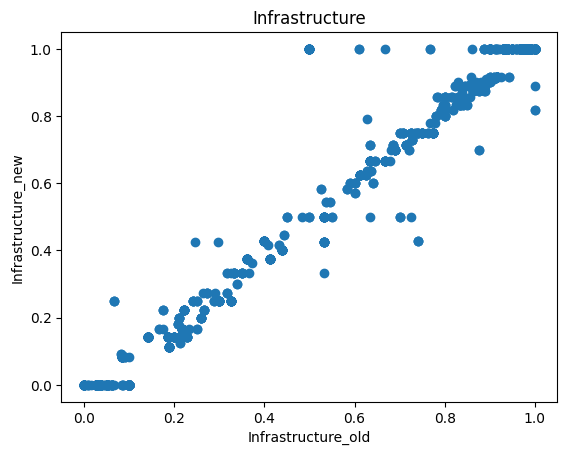

                  PolityName  Year  Information_old  Information_new      diff
958             cn_peiligang -5100              0.0         0.578094  0.578094
943             cn_peiligang -6600              0.0         0.578094  0.578094
1258    mx_basin_of_mexico_7   500              0.0         0.578094  0.578094
1257    mx_basin_of_mexico_7   400              0.0         0.578094  0.578094
1294  us_proto_haudenosaunee  1400              0.0         0.578094  0.578094
1295  us_proto_haudenosaunee  1500              0.0         0.578094  0.578094
1256    mx_basin_of_mexico_7   300              0.0         0.578094  0.578094
1255    mx_basin_of_mexico_7   200              0.0         0.578094  0.578094
1254    mx_basin_of_mexico_7   100              0.0         0.578094  0.578094
957             cn_peiligang -5200              0.0         0.578094  0.578094


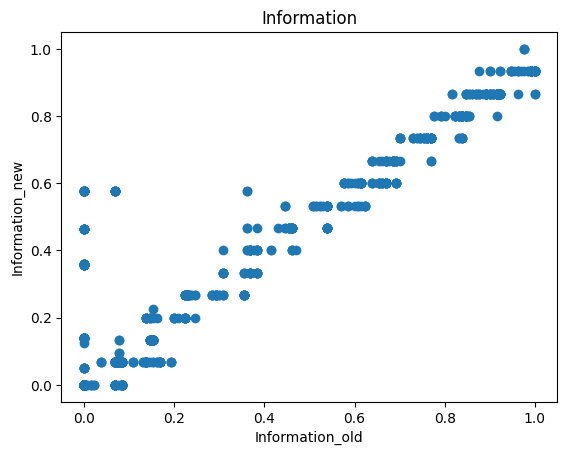

           PolityName  Year  Money_old  Money_new      diff
589      ye_ziyad_dyn   900   0.000000   0.833333  0.833333
590      ye_ziyad_dyn  1000   0.000000   0.833333  0.833333
926       id_medang_k   800   0.166667   0.833333  0.666667
536  tr_neo_hittite_k -1000   0.166667   0.692126  0.525459
535  tr_neo_hittite_k -1100   0.166667   0.692126  0.525459
83    fr_la_tene_a_b1  -400   0.375000   0.833333  0.458333
955      cn_peiligang -5400   0.243100   0.692126  0.449026
942      cn_peiligang -6700   0.243100   0.692126  0.449026
958      cn_peiligang -5100   0.243100   0.692126  0.449026
957      cn_peiligang -5200   0.243100   0.692126  0.449026


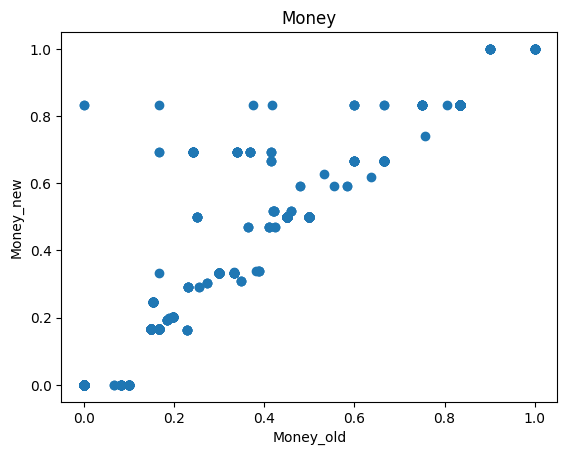

In [6]:
scale_cols = ['Pop','Terr','Cap']
non_scale_cols = ['Government','Infrastructure','Information','Money']
for col in scale_cols+['Hierarchy']+non_scale_cols:
    df_merge = df[['PolityName','Year',col]].merge(dataset.scv_imputed[['PolityName','Year',col]], on=['PolityName','Year'], suffixes=('_old','_new'))
    df_merge['diff'] = df_merge[col+'_old'] - df_merge[col+'_new']
    df_merge['diff'] = df_merge['diff'].abs()

    df_merge = df_merge.sort_values('diff', ascending=False)
    print(df_merge.head(10))

    plt.plot(df_merge[col+'_old'], df_merge[col+'_new'], 'o')
    plt.ylabel(col+'_new')
    plt.xlabel(col+'_old')
    plt.title(col)
    plt.show()

In [7]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    
    # remove rows without a value 100 yrs later
    mask = (group['Year'].shift(-1) - group['Year'] != 100)
    indices = group.index.intersection(mask[mask].index)
    if len(indices) > 2:
        print(len(indices)-1)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan


2
2
2
3
6
3
2
3


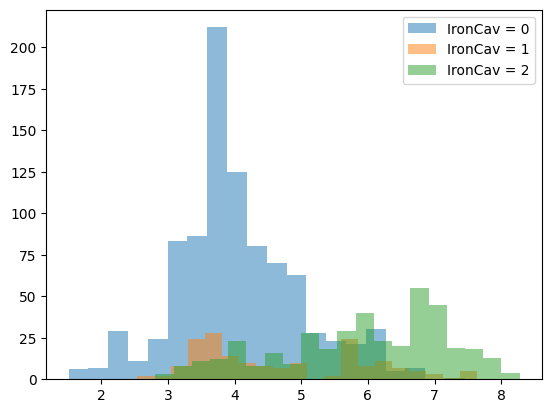

In [8]:
plt.hist(dr.loc[dr["IronCav"] == 0, "Scale_1"], bins=20, alpha=0.5, label="IronCav = 0");
plt.hist(dr.loc[dr["IronCav"] == 1, "Scale_1"], bins=20, alpha=0.5, label="IronCav = 1");
plt.hist(dr.loc[dr["IronCav"] == 2, "Scale_1"], bins=20, alpha=0.5, label="IronCav = 2");
plt.legend()


In [85]:
x_cols = ['Scale_1','Scale_sq','Agri','IronCav', 'Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Comp'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     3730.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:29:26   Log-Likelihood:                -478.38
No. Observations:                1158   AIC:                             966.8
Df Residuals:                    1153   BIC:                             992.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.0343      0.054     19.298      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_23792\4294865928.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Comp'], inplace=True)


In [ ]:
def analyze_residuals(values, residuals, bins):
    """
    Analyze residuals by binning comp values and calculating statistics
    
    Args:
        comp_values (array-like): Competitiveness values
        residuals (array-like): Model residuals
        bin_size (float): Size of bins (default 0.1)
    
    Returns:
        pandas.DataFrame with columns: Value, mean, SE, n, lower, upper
    """
    import pandas as pd
    import numpy as np

    bin_size = bins[1] - bins[0]
    # Initialize results
    results = []
    
    # Calculate stats for each bin
    for bin_center in bins[:-1]:
        mask = ((values >= bin_center - bin_size) & 
                (values < bin_center + bin_size))
        bin_residuals = residuals[mask]
        
        if len(bin_residuals) > 0:
            mean = np.mean(bin_residuals)
            se = np.std(bin_residuals)
            results.append({
                'Value': bin_center + bin_size/2,
                'mean': mean,
                'SE': se/np.sqrt(len(bin_residuals)),
                'n': len(bin_residuals),
                'lower': mean - se,
                'upper': mean + se
            })
    
    # Convert to dataframe
    df = pd.DataFrame(results)
    return df

(0.0, 1.0)

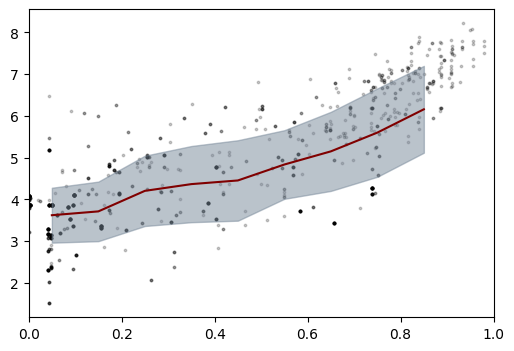

In [109]:
bins = np.arange(0.0, 1, 0.1)
results = analyze_residuals(Xy['Comp'].values, Xy['Scale_1'].values, bins)

plt.figure(figsize=(6, 4))
plt.scatter(Xy['Comp'].values, Xy['Scale_1'].values, color='k', alpha=0.2, label='Predictions', s=3)

plt.plot(results['Value'], results['mean'], color='maroon')
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)

plt.xlim(.0, 1)


(0.0, 0.95)

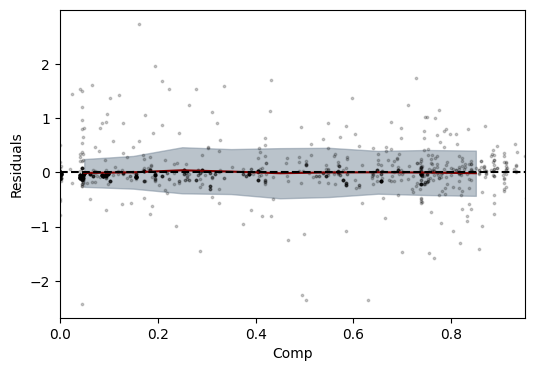

In [95]:
residuals = y['Scale_t'] - predictions.values
comp_values = Xy['Comp'].values
bins = np.arange(0, 1, 0.1)
results = analyze_residuals(comp_values, residuals, bins)
results_before = results.copy() 
residuals_before = residuals.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
x = np.linspace (-2,12,100)
plt.scatter(Xy['Comp'], residuals, color='k', alpha=0.2, label='Predictions', s=3)

plt.xlim(0.0, 0.95)

In [ ]:
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

In [ ]:
thresh_start = np.arange(0.1, 0.9 , 0.02)
thresh_end = np.arange(0.5, 0.9, 0.01)
# x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','Miltech','IronCav','Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p', 'log-likelyhood','minres'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp >= thresh_s)&(Xy.Comp <= thresh_e)
        X['Comp'] = 0
        X.loc[mask, 'Comp'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Scale_t'].values - predictions))
        }, ignore_index=True)



C:\Users\matil\AppData\Local\Temp\ipykernel_25424\759385755.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_25424\759385755.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\matil\AppData\Local\Temp\ipykernel_25424\759385755.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Local\

In [ ]:
results.sort_values('AIC', ascending=True)

,thresh_start,thresh_end,n,R2,R2_adj,AIC,p,log-likelyhood,minres
681,0.44,0.51,1158.0,0.927488,0.927237,979.201043,0.0,-484.600521,0.186370
721,0.46,0.51,1158.0,0.927488,0.927237,979.201043,0.0,-484.600521,0.186370
761,0.48,0.51,1158.0,0.927461,0.927209,979.635075,0.0,-484.817537,0.185677
1220,0.70,0.70,1158.0,0.927308,0.927056,982.077641,0.0,-486.038821,0.183230
1054,0.62,0.64,1158.0,0.927258,0.927006,982.866386,0.0,-486.433193,0.184153
...,...,...,...,...,...,...,...,...,...
627,0.40,0.77,1158.0,0.926887,0.926634,988.754552,0.0,-489.377276,0.183119
956,0.56,0.86,1158.0,0.926887,0.926634,988.754553,0.0,-489.377276,0.183118
819,0.50,0.69,1158.0,0.926887,0.926634,988.754553,0.0,-489.377277,0.183117
465,0.32,0.75,1158.0,0.926887,0.926634,988.754554,0.0,-489.377277,0.183119


In [ ]:
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[0].values
print(thresh_min)
mask = (Xy.Comp >= thresh_s)&(Xy.Comp <= thresh_e)
X['Comp'] = 0
X.loc[mask, 'Comp'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

[0.44 0.51]
                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     3655.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:18:15   Log-Likelihood:                -489.28
No. Observations:                1158   AIC:                             988.6
Df Residuals:                    1153   BIC:                             1014.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.0117      0.054     18.

C:\Users\matil\AppData\Local\Temp\ipykernel_25424\4236849182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0


Text(0.5, 1.0, 'Residuals with and without thresholds model')

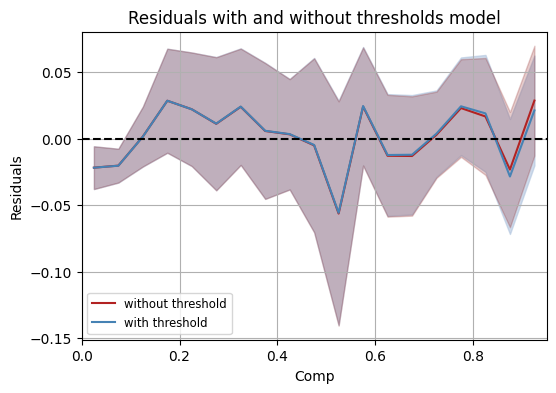

In [ ]:
residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0, 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(0.0, 0.95)
# plt.ylim(-0.5, 0.5)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

In [ ]:
x_cols = ['Comp','Agri','IronCav','Comp_sq','Scale_1']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Scale_1'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     4532.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:44:43   Log-Likelihood:                 1339.8
No. Observations:                1161   AIC:                            -2670.
Df Residuals:                    1156   BIC:                            -2644.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Comp           1.0422      0.031     34.068      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_21376\2085515406.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Scale_1'], inplace=True)


(1.0, 9.0)

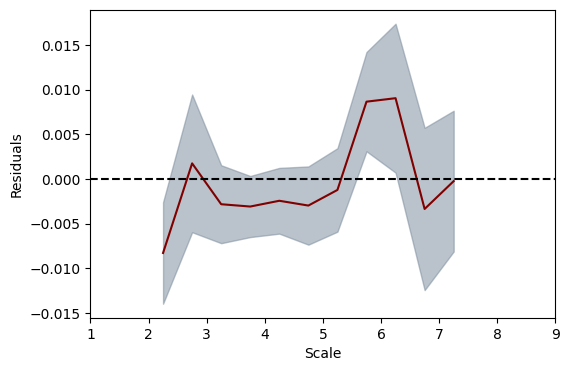

In [ ]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)

results = analyze_residuals(scale_values, residuals, bins)
results_before = results.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Scale')
plt.ylabel('Residuals')
plt.xlim(1, 9.)

In [ ]:
thresh_start = np.arange(2, 8 , 0.1)
thresh_end = np.arange(6, 10, 0.1)
x_cols = ['Scale_1','Comp_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p','log-likelyhood','minres'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp > thresh_s) & (Xy.Comp < thresh_e)
        X['Scale_1'] = 0
        X.loc[mask, 'Scale_1'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue,
            'log-likelyhood': model.llf,
            'minres': np.mean(np.abs(y['Comp_t'].values - predictions))
        }, ignore_index=True)


C:\Users\matil\AppData\Local\Temp\ipykernel_21376\971872464.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_21376\971872464.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\matil\AppData\Local\Temp\ipykernel_21376\971872464.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
C:\Users\matil\AppData\

In [ ]:
thresh_min = results.sort_values('minres', ascending=True)[['thresh_start','thresh_end']].iloc[1].values
print(thresh_min)

mask = (Xy.Scale_1 >= thresh_min[0]) & (Xy.Scale_1 < thresh_min[1])
X['Scale_1'] = 0
X.loc[mask, 'Scale_1'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

[5.9 9.6]
                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     3042.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:45:08   Log-Likelihood:                 1344.4
No. Observations:                1161   AIC:                            -2675.
Df Residuals:                    1154   BIC:                            -2639.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.0111      0.009      1.30

C:\Users\matil\AppData\Local\Temp\ipykernel_21376\2309509417.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0


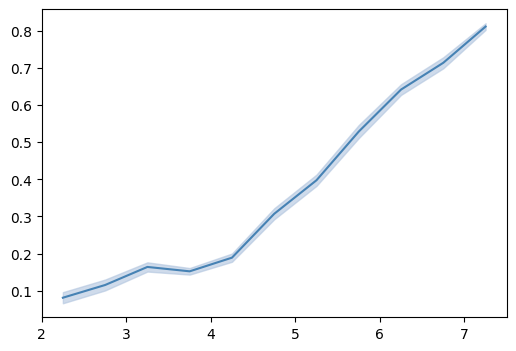

In [ ]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)
results = analyze_residuals(scale_values, y['Comp_t'].values, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)


Text(0.5, 1.0, 'Residuals with and without thresholds model')

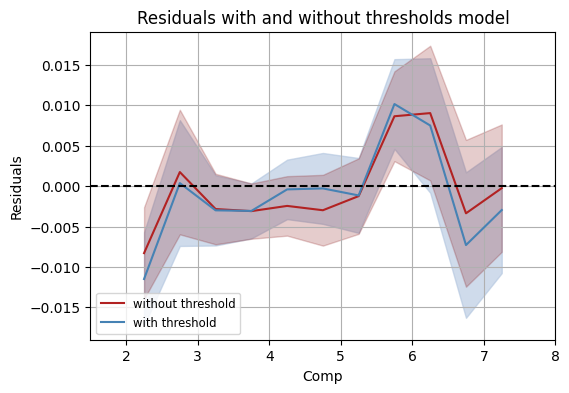

In [ ]:
residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8, 0.5)
results = analyze_residuals(scale_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(1.5, 8)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

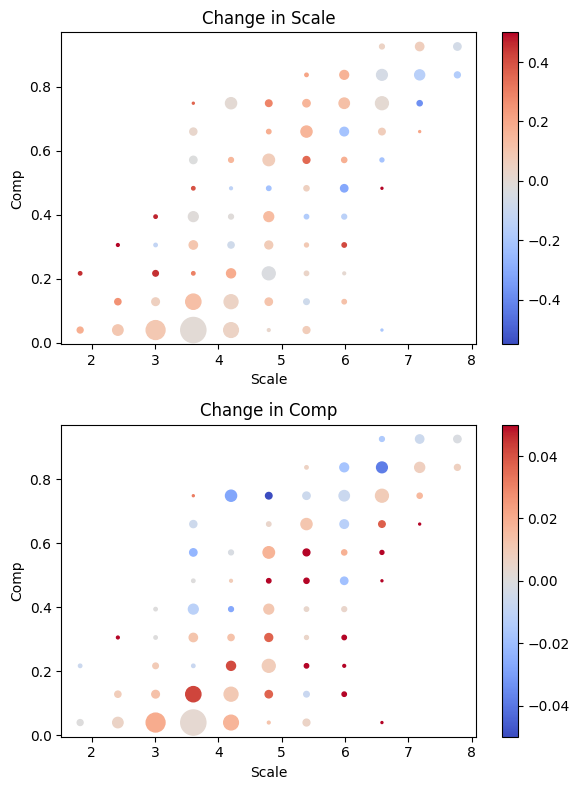

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

x_cols = ['Scale_1','Comp']
y_col = ['d_Scale','d_Comp']
Xy = dr[y_col+x_cols].dropna()

x = Xy["Scale_1"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std/2 > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std/2 > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*2, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*2, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_21376\1731759286.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_21376\1731759286.py:14: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


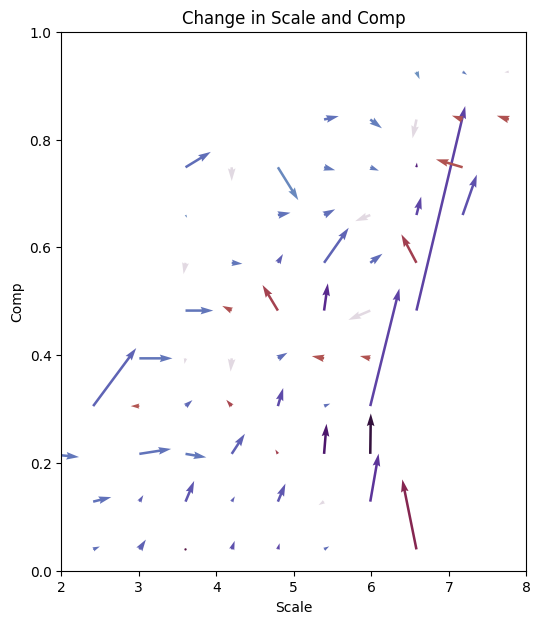

In [ ]:
import seaborn as sns


# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 1)
v = np.clip(grid_2.values, -0.1, 0.1)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()

C:\Users\matil\AppData\Local\Temp\ipykernel_21376\1355743016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
C:\Users\matil\AppData\Local\Temp\ipykernel_21376\1355743016.py:50: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
C:\Users\matil\AppData\Local\Temp\ipykernel_21376\1355743016.py:51: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


ValueError: Argument U has a size 121 which does not match 144, the number of arrow positions

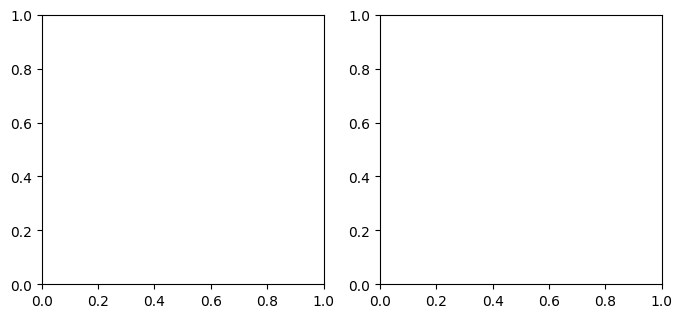

In [ ]:
import seaborn as sns

cav = [0, 1, 2]

colors = ['firebrick', 'steelblue', 'darkorange']

fig, ax = plt.subplots(1,2,figsize=(8, 3.5))
cav = [0,1]
# plt.minorticks_on()
for n,c in enumerate(cav):
    Xy = dr.loc[(dr.Cavalry == c)]
    x = Xy["Scale_1"].values
    y = Xy["Comp"].values
    z1 = Xy["d_Scale"].values
    z2 = Xy["d_Comp"].values

    grid_size = 11

    df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

    # Define the grid
    x_bins = np.linspace(min(x), max(x), grid_size + 1)
    y_bins = np.linspace(min(y), max(y), grid_size + 1)

    # Bin the data
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
    grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
    counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

    grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
    grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
    counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

    # create vector plot
    pink_r = plt.cm.get_cmap('pink_r')
    # sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
    u = np.clip(grid_1.values, -1, 1)
    v = np.clip(grid_2.values, -0.1, 0.1)
    u = grid_1.values
    v = grid_2.values

    std_1 = grid_1_std.values/grid_1.values
    std_2 = grid_2_std.values/grid_2.values

    std = np.sqrt(std_1**2 + std_2**2)
    std = np.clip(std, 0, 20)
    t_norm = np.reshape(std, -1)
    t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

    x, y = np.meshgrid(x_bins, y_bins)
    # color arrows according to angle
    color = np.arctan2(v, u)
    color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

    ax[n].quiver(x, y, u, v, scale_units='xy', angles='xy',
            color=color.reshape(-1, 4),
            alpha=1.,  scale=1.1)
    ax[n].set_xlim(1, 8)
    ax[n].set_ylim(0, 1.)
    ax[0].set_ylabel('Comp')
    ax[n].set_title(f'Cavalry: {c}')
    ax[n].grid(True,  alpha=0.5)
    
    ax[n].set_xlabel('Scale')
plt.suptitle('Change in Scale and Comp')
plt.tight_layout()
plt.show()

In [ ]:
changes = pd.DataFrame(columns = ['NGA', 'PolityName', 'Scale', 'Comp', 'd_Scale', 'd_Comp'])

scv_imp_nga = dataset.scv_imputed.groupby('NGA')
for nga, group in scv_imp_nga:
    group = group.sort_values(['Year', 'PolityID'])

    pol_nga = group.groupby('PolityID')
    polities = pol_nga['PolityName'].first()
    scales = pol_nga['Scale_1'].apply(np.mean)
    comps = pol_nga['Comp'].apply(np.mean)
    years = pol_nga['Year'].apply(np.mean)

    d_year = (years.shift(-1)-years)/100
    d_scales = (scales.shift(-1)-scales)/d_year
    d_comps = (comps.shift(-1) - comps)/d_year

    df_temp = pd.DataFrame({'NGA': nga, 'PolityName':polities, 'Scale': scales, 'Comp': comps, 'd_Scale': d_scales, 'd_Comp': d_comps})
    changes = changes.append(df_temp)
changes.dropna(subset = ['d_Scale', 'd_Comp'], inplace = True)

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/354031872.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_te

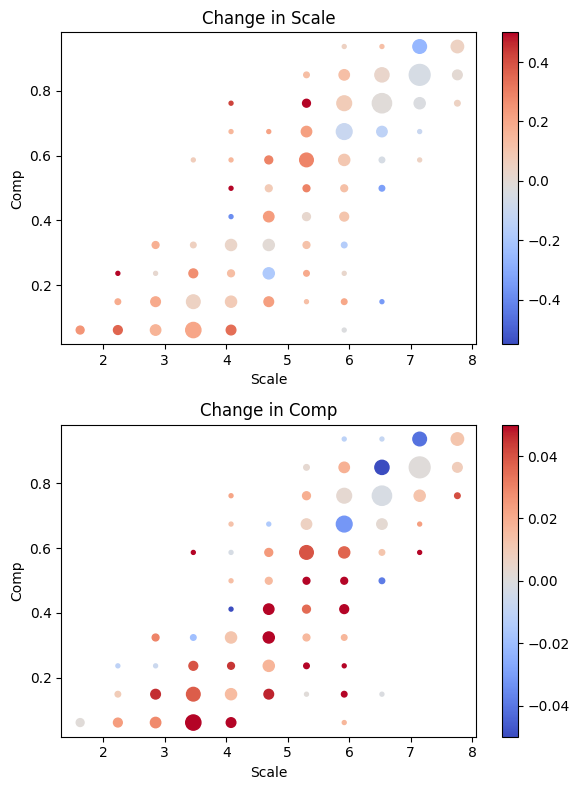

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

Xy = changes

x = Xy["Scale"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*8, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*8, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_52001/1507440410.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')


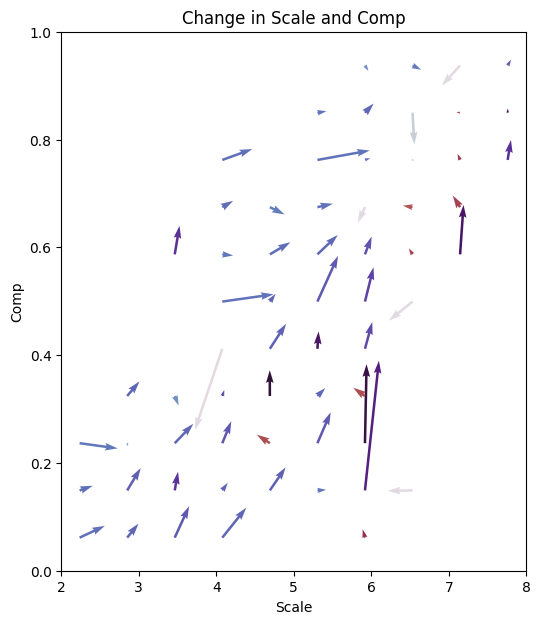

In [ ]:
import seaborn as sns
# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 2)
v = np.clip(grid_2.values, -0.1, 0.2)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()